<a href="https://colab.research.google.com/github/GiacomoDiFa/Progetto-MN/blob/main/progetto_MN_Di_Fabrizio_Montanari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate

Compile the following notebook and share a link with me sending and e-mail to giovanni.stabile@uniurb.it at least one week before the oral examination. All the implemented function will have to be properly documented and commented.

Compile The following Cell with your information. In case it is a group project, put the info for all the group members

Name1: Giacomo \
Surname1: Di Fabrizio\
Email1: 

Name2: Matteo Marco\
Surname2: Montanari\
Email2: 

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

# Mathematical Background

The physical interpretation of this problem is related to the modelling of an elastic string, which occupies at rest the space $[0, \pi]$ and is fixed at the two extremes. The unknown $u(x)$ represents the displacement of the string at the point $x$, and the right-hand side models a prescribed force $f(x)$ on the string.

For the numerical discretization of the problem, we consider a **Finite Difference (FD) Approximation**. Let $n$ be an integer, a consider a uniform subdivision of the interval $(0,\pi)$ using $n$ equispaced points, denoted by $\{x_i\}_{i=0}^n$ . Moreover, let $u_i$ be the FD approximation of $u(x_i)$, and similarly $f_i \approx f(x_i)$.

In order to formulate the discrete problem, we consider a FD approximation of the left-hand side, as follows ($4^{th}$ order finite difference approximation of the second order derivative):

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

The problem that we need to solve is

$$
u_i = 0 \qquad\qquad\qquad\qquad\qquad i=0,
$$

$$
\frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2} = - f_i \qquad\qquad\qquad  i=1, \ldots, n-1,\qquad\qquad\qquad(P)
$$

$$
u_i = 0 \qquad\qquad\qquad\qquad\qquad i=n.
$$

Then, let us collect al the unknowns $\{u_i\}_{i=0}^n$ in a vector $\mathbf{u}$. Then, (P) is a linear system
$$
A \mathbf{u} = \mathbf{f}.
$$

In [2]:
# 4th order finite difference scheme
def finDif(omega, f, n, bc):
    
    assert n > 4, "n must be greater than 4!"
    assert omega[0] < omega[1], "Discretization interval is not correct!" 
    
    # d(x, y) = | x - y |
    h = np.abs(omega[0] - omega[1]) / (n - 1)
        
    x = np.linspace(0, 1, n)    
    
    termine_noto = -f(x)
    termine_noto[0] = bc[0]
    termine_noto[-1] = bc[1]

    # create discretization matrix A
    A = np.zeros((n, n))
  
    a = -np.ones((n-2, )) 
    b = 16*np.ones((n-1, ))
    c = -30*np.ones((n, ))

    A = (np.diag(a, -2) + np.diag(a, +2) + np.diag(b, -1) + np.diag(b, +1) + np.diag(c, 0))

    A /= (12*h**2)
    
    A[0, :] = np.zeros(n)
    A[1, :] = np.zeros(n)

    A[n-1, :] = np.zeros(n)
    A[n-2, :] = np.zeros(n)

    A_second_row = np.array([-1.0, 2.0, -1.0]) / (h**2)
    A_second_last_row = np.array([-1.0, 2.0, -1.0]) / (h**2)
    
    A[1, 0:3] = A_second_row
    A[n-2, n-3:n] = A_second_last_row
  
    A[0, 0] = 1
    A[-1, -1] = 1

    return A, termine_noto

In [3]:
omega = [0, np.pi]
f = lambda x : np.sin(x)
n = 5
bc = [0, 0]
A, b = finDif(omega, f, n, bc)
print("A =")
print(A)

A =
[[ 1.          0.          0.          0.          0.        ]
 [-1.62113894  3.24227788 -1.62113894  0.          0.        ]
 [-0.13509491  2.16151858 -4.05284735  2.16151858 -0.13509491]
 [ 0.          0.         -1.62113894  3.24227788 -1.62113894]
 [ 0.          0.          0.          0.          1.        ]]


Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A):
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=np.tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = np.triu(A)
    return L, U

In [5]:
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = np.sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = np.sqrt(A[-1,-1])
    L=np.tril(A)
    return L, L.transpose()

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
    x = np.zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    
    for i in range(1,N):
        x[i] = (rhs[i] - np.dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x

In [7]:
def U_solve(U,rhs):
    x = np.zeros_like(rhs)
    N = len(U)
              
    x[-1] = rhs[-1]/U[-1,-1]
    
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] -np.dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
    
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

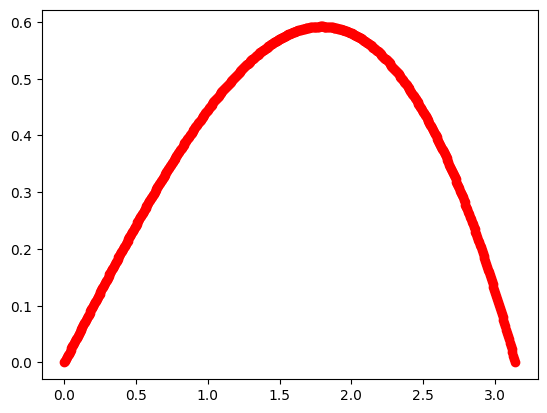

In [8]:
omega = [0, np.pi]
f = lambda x : np.sin(x)
n = 500
bc = [0, 0]
A, b = finDif(omega, f, n, bc)
x = np.linspace(0, np.pi, n)
L, U = LU(A)
w = L_solve(L, b)
u = U_solve(U, w)

_ = plt.plot(x, u, 'ro')

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = \{0,1\}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

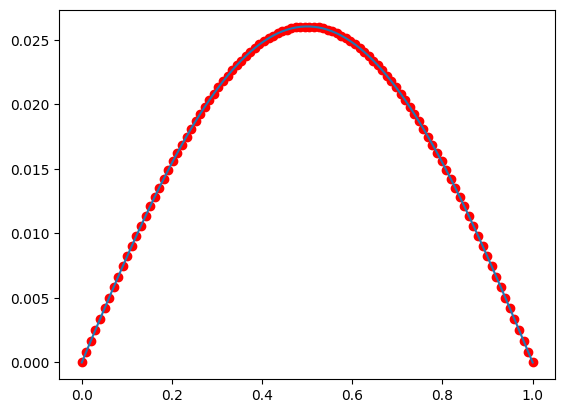

In [9]:
omega_new = [0, 1]
n_new = 100
x_new = np.linspace(0, 1, n_new)
f_new = lambda x_new : x_new*(1 - x_new)
bc_new = [0, 0]
A_new, b_new = finDif(omega_new, f_new, n_new, bc_new)
A1_new = A_new.copy()
u_new = np.linalg.solve(A1_new, b_new) 

u_ex = (x_new**4)/12.0 - (x_new**3)/6.0 + x_new/12.0

# Plot the FD and exact solution
_ = plt.plot(x_new, u_new, 'ro')
_ = plt.plot(x_new, u_ex)

In [10]:
# table where you show the decay of the error w.r.t. the number of grid points
print(np.linalg.norm(u_ex - u_new, 2))

2.3388862814248566e-05


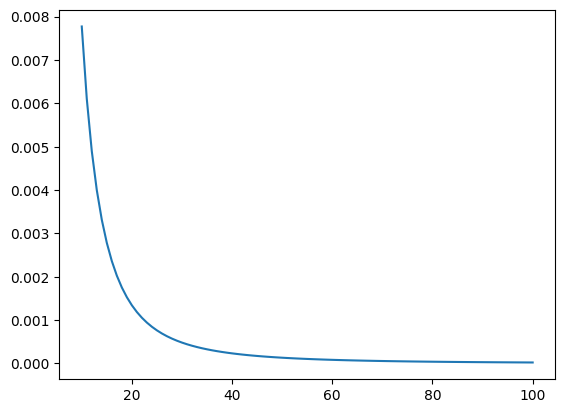

In [11]:
omega_new = [0, 1]
bc_new = [0, 0]

error = []
n_points = np.array([x for x in range(10, 101)])

for j in n_points:
    x_new = np.linspace(0, 1, j)
    f_new = lambda x_new : x_new*(1 - x_new)
    u_ex = (x_new**4)/12.0 - (x_new**3)/6.0 + x_new/12.0

    A_new, b_new = finDif(omega_new, f_new, j, bc_new)
    A1_new = A_new.copy()
    u_new = np.linalg.solve(A1_new, b_new) 
    
    error.append(np.linalg.norm(u_ex - u_new, 2))
    
plt.plot(n_points, error)

In [12]:
# NB python dictionaries
tab = {n : e for n, e in zip(n_points, error)}
tab

{10: 0.007772999668146033,
 11: 0.006105623346817107,
 12: 0.004897181708718345,
 13: 0.003997793144152499,
 14: 0.0033131111752743186,
 15: 0.002781637039242217,
 16: 0.0023620525901975526,
 17: 0.0020258560136231295,
 18: 0.0017529253036562427,
 19: 0.0015287601683104048,
 20: 0.0013427188575327491,
 21: 0.0011868626029950208,
 22: 0.0010551811788507644,
 23: 0.0009430633336482032,
 24: 0.0008469280079351693,
 25: 0.0007639632286492956,
 26: 0.0006919384218358439,
 27: 0.0006290676150871532,
 28: 0.0005739084509371638,
 29: 0.0005252867535405623,
 30: 0.0004822395651361836,
 31: 0.0004439716925776177,
 32: 0.00040982224605802845,
 33: 0.0003792386450684837,
 34: 0.0003517562584495953,
 35: 0.0003269823342781275,
 36: 0.000304583223619407,
 37: 0.00028427415365950634,
 38: 0.00026581098897695724,
 39: 0.00024898355400228793,
 40: 0.00023361018998267757,
 41: 0.00021953329385579953,
 42: 0.00020661564330137972,
 43: 0.00019473735445336103,
 44: 0.00018379335170209447,
 45: 0.0001736912

Exploit the derived LU factorizations to compute the determinant of the system's matrix $A$ using the original problem formulation.

In [13]:
def determinant(A):
    L, U = LU(A)
    size = A.shape[0]
    determinant = 1
    
    for i in range(size):
        determinant *= U[i, i]

    return determinant

print(determinant(A))
print(np.linalg.det(A))

inf
inf


<ipython-input-13-844bdda38043>:7: RuntimeWarning: overflow encountered in double_scalars
  determinant *= U[i, i]
/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [14]:
def condNumb(A):
    condNu = np.linalg.cond(A)
    return condNu

condNumb(A)
# forse si deve fare diversamente? Boohh che poi il prof si è confuso secondo me perchè chiedeva di calcolare il determinante
# (vedi cella sopra) e non il numero di condizionamento

2130922.837967708

In [15]:
# ho trovato questa formula ma mi sa che non fa
def condNum(A):
    return np.linalg.norm(A,2) * np.linalg.norm(np.linalg.inv(A),2)

#def condNumWithOurInverse(A):
#  return np.linalg.norm(A,2) * np.linalg.norm(inverseMatrix(A),2)

print(np.linalg.cond(A))
print(condNum(A))
#print(condNumWithOurInverse(A))

2130922.837967708
2130922.837889514


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

500 2609.664909589068
0.791275207765697


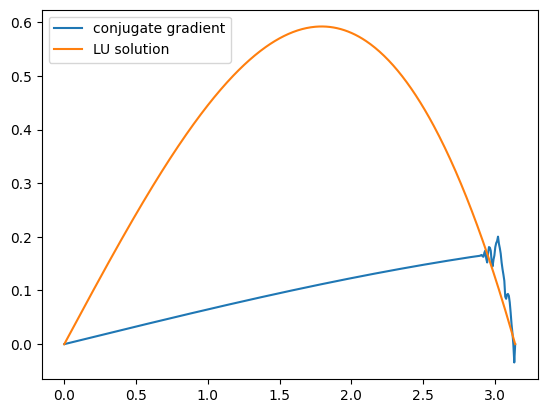

In [16]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    N=len(A)
    x = np.zeros_like(b)
    tol = eps + 1
    it = 0
    r = b - np.dot(A,x)
    rho_old = 1.
    p_old = np.zeros_like(b)
    while (it < nmax and tol > eps):
        it += 1
        z = np.linalg.solve(P,r)
        rho = np.dot(r,z)
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = np.dot(A,p)
        alpha = rho/(np.dot(p,q))
        x += p*alpha
        r -= q*alpha
        
        p_old = p
        rho_old = rho
        
        tol = np.linalg.norm(r,2)
        
    print(it, tol)
    return x
sol_conjugate_gradient = conjugate_gradient(A, b, np.identity(len(A)))
print(np.linalg.norm(sol_conjugate_gradient - u)/np.linalg.norm(u))
#non so se torna, ho copiato i codici paro paro
#forse non torna perchè la matrice fa cagare?
x_newnew = np.linspace(0,np.pi,n)
plt.plot(x_newnew,sol_conjugate_gradient, label='conjugate gradient')
plt.plot(x_newnew,u, label='LU solution')
plt.legend()

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [17]:
#TODO

Given the original $Au = b$ system, implement an algorithm to compute the largest and smallest eigenvalues and the associated eigenvectors of the matrix $A$.

In [18]:
# let's implement Power Method
z0 = np.ones_like(b)
def PM(A,z0,tol=1e-20,nmax=500):
    q = z0/np.linalg.norm(z0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        q = z/np.linalg.norm(z,2)
        
        it += 1
    print("error =", err, "iterations =", it)
    return l,q

l,x = PM(A,z0)
l_np, x_np = np.linalg.eig(A)
print("l_max =", abs(l), "\nx_max =", x)
print("\nNumpy Linalg")
print("l_max =", max(abs(l_np)), "\nx_max =", x_np[:, np.argmax(abs(l_np))])
print(l_np)


error = 165.4806414975151 iterations = 500
l_max = 134352.1425668034 
x_max = [ 0.00000000e+00  1.82979819e-03  1.33891737e-02 -2.75297642e-02
  4.14593598e-02 -5.49905748e-02  6.80013476e-02 -8.03745268e-02
  9.20030920e-02 -1.02791488e-01  1.12656916e-01 -1.21530343e-01
  1.29357228e-01 -1.36097947e-01  1.41727932e-01 -1.46237508e-01
  1.49631473e-01 -1.51928402e-01  1.53159743e-01 -1.53368697e-01
  1.52608943e-01 -1.50943235e-01  1.48441901e-01 -1.45181293e-01
  1.41242225e-01 -1.36708422e-01  1.31665024e-01 -1.26197170e-01
  1.20388688e-01 -1.14320902e-01  1.08071592e-01 -1.01714099e-01
  9.53165834e-02 -8.89414550e-02  8.26449517e-02 -7.64768756e-02
  7.04804698e-02 -6.46924288e-02  5.91430263e-02 -5.38563462e-02
  4.88506011e-02 -4.41385218e-02  3.97278008e-02 -3.56215753e-02
  3.18189344e-02 -2.83154367e-02  2.51036258e-02 -2.21735346e-02
  1.95131678e-02 -1.71089555e-02  1.49461741e-02 -1.30093278e-02
  1.12824898e-02 -9.74960211e-03  8.39473247e-03 -7.20229116e-03
  6.15720786

In [19]:
def IPM(A,x0,mu,tol=1e-20,nmax=500):
    M = A -mu*np.eye(len(A))
    P,L,U = scipy.linalg.lu(M)
    err = tol + 1.
    it = 0
    q = x0/np.linalg.norm(x0,2)
    while it < nmax and err > tol :
        y = scipy.linalg.solve(L,np.dot(P.T,q))
        x = scipy.linalg.solve(U,y)
        q = x/np.linalg.norm(x,2)
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        it += 1
    print("error =", err, "iterations =", it)
    print("lambda =", l)
    return l,q

# compute IPM
l, x = IPM(A, z0, 0)
# use numpy library for comparing    
l_np, x_np = np.linalg.eig(A)

print("l_min =", abs(l), "\nx_min =", x)
print("\nNumpy Linalg")

print("l_min =", min(abs(l_np)), "\nx_min =", x_np[:, np.argmin(abs(l_np))])


error = 0.37905543589733093 iterations = 500
lambda = 0.1742819723155608
l_min = 0.1742819723155608 
x_min = [0.04519717 0.04512195 0.04504496 0.04496947 0.0448957  0.04482365
 0.04475331 0.04468466 0.04461767 0.04455234 0.04448865 0.04442657
 0.0443661  0.04430722 0.0442499  0.04419414 0.04413992 0.04408721
 0.04403601 0.0439863  0.04393806 0.04389127 0.04384593 0.043802
 0.04375949 0.04371836 0.04367861 0.04364022 0.04360318 0.04356746
 0.04353306 0.04349995 0.04346812 0.04343757 0.04340826 0.04338019
 0.04335334 0.0433277  0.04330324 0.04327997 0.04325785 0.04323688
 0.04321705 0.04319833 0.04318071 0.04316418 0.04314873 0.04313433
 0.04312098 0.04310866 0.04309736 0.04308705 0.04307774 0.0430694
 0.04306202 0.04305559 0.04305009 0.04304551 0.04304184 0.04303905
 0.04303715 0.04303611 0.04303592 0.04303657 0.04303805 0.04304034
 0.04304342 0.04304729 0.04305194 0.04305734 0.0430635  0.04307038
 0.04307799 0.04308631 0.04309532 0.04310502 0.04311539 0.04312642
 0.04313809 0.0431504  

Compute the inverse of the matrix A exploiting the derived LU factorization

In [20]:
def inverseMatrix(A):
    size = round(np.sqrt(A.size))
    E = np.eye(size)
    X = np.zeros_like(E)
    W = np.zeros_like(E)
    L, U = LU(A)

    for i in range(size):
        W[:, i:] = L_solve(L, E[:,i:])
        X[:, i:] = U_solve(U, W[:,i:])
  
    #I = A@X  #uncomment for see identity matrix result of A@A**-1
    #print(I) #uncomment for see identity matrix result of A@A**-1
    return X

inverseMatrix(A)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.97995992e-01,  4.26105279e-05, -3.66378497e-05, ...,
        -1.53161960e-07,  9.21959742e-08,  2.00400802e-03],
       [ 9.95991984e-01,  4.55842496e-05, -7.32756993e-05, ...,
        -3.06323919e-07,  1.84391948e-07,  4.00801603e-03],
       ...,
       [ 4.00801603e-03,  1.84391948e-07, -3.06323919e-07, ...,
        -7.32756993e-05,  4.55842496e-05,  9.95991984e-01],
       [ 2.00400802e-03,  9.21959742e-08, -1.53161960e-07, ...,
        -3.66378497e-05,  4.26105279e-05,  9.97995992e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

### Backward Euler

$$
\frac{y_{n}-y_{n-1}}{h} = f(y_{n}, t_{n})
$$

witch led to this updating formula:

$$
y_{n} = y_{n-1} + h f(y_{n}, t_{n}) = y_{n-1} + h (-t) y_{n}^2 
$$

to find $y_n$ in:

$$
y_{n} = y_{n-1} + h (-t) y_{n}^2 
$$

we find zeros of function $g(y)$:

$$
g(y_n) = y_{n} - y_{n-1} - h (-t) y_{n}^2 = 0 
$$

so:

$$
g(y_n) = y_{n} - y_{n-1} + h t y_{n}^2
$$

## Newton's method
$$
q^k = g^{\prime}(y^k)
$$

$$
y^{k+1} = y^k - \frac{g(y^k)}{q^k}
$$

where:

$$
g^{\prime}(y^k) = 2 h t y_n + 1
$$

In [21]:
def newton(f,f_prime,x0,eps =1e-30 ,n_max =1000000 ):
  err = abs(f(x0))
  errors = [err]
  it = 0
  x = x0
  while (err > eps and it < n_max):
      qk = f_prime(x)
      if abs(qk) < 1e-12:
          raise RuntimeError("f_prime(x) is close to zero")
      x_new = x - f(x)/qk
      err = abs(f(x_new))
      x = x_new
      errors.append(err)
      it += 1
  return x, errors

In [22]:
def be(y0, t0, tf, h):
  timesteps = np.arange(t0, tf + 1e-10, h)
  sol = np.zeros_like(timesteps)
  sol[0] = y0
  
  for i in range(1, len(sol)):
    t = timesteps[i-1]
    f = lambda z: h * t * z**2 + z - sol[i-1]
    f_prime = lambda z: 2 * h * t * z + 1
    sol[i],_ = newton(f, f_prime, y0)
  
  return sol, timesteps

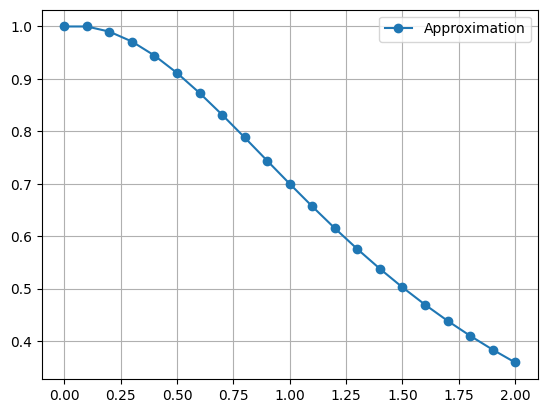

In [23]:
t0 = 0
tf = 2
y0 = 1
y, t = be(y0, t0, tf, 0.1)

plt.plot(t, y, 'o-', label='Approximation')
plt.legend()
plt.grid()

#### Exact solution
$$
y(x) = \int{-t y^2(x) dx} = -t \frac{y^3(x)}{3}
$$

OPPURE MEGLIO COSI?

$$
y = \int{-t y^2 dy} = -t \frac{y^3}{3} + C
$$

dato che deve essere $y(0) = 1$ allora $C = 1$

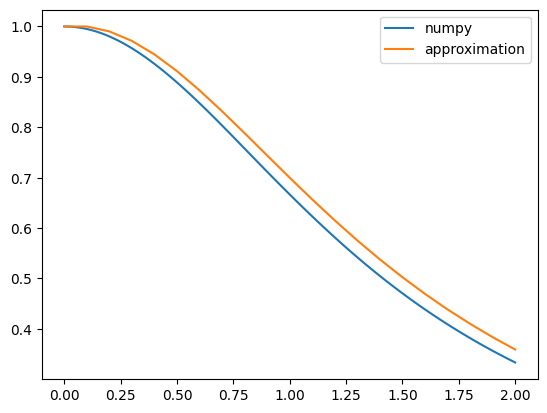

In [24]:
# Definisci l'equazione differenziale
def ode_func(t, y):
    return -t*y**2  # Ad esempio, consideriamo l'equazione y' = t * y

# Definisci le condizioni iniziali
t0 = 0  # Tempo iniziale
y0 = 1  # Valore iniziale di y(t0)

# Definisci l'intervallo di tempo in cui risolvere l'ODE
t_start = t0  # Inizio dell'intervallo di tempo
t_end = 2  # Fine dell'intervallo di tempo
num_points = 100  # Numero di punti di campionamento desiderati
t_span = np.linspace(t_start, t_end, num_points)

# Risolvi l'ODE con il passo di campionamento personalizzato
sol = scipy.integrate.solve_ivp(ode_func, [t_start, t_end], [y0], t_eval=t_span)

# Ottieni i risultati
t = sol.t  # Array dei tempi
y = sol.y[0]  # Array dei valori di y corrispondenti ai tempi

# Stampa i risultati
#for i in range(len(t)):
#    print(f"t: {t[i]}, y: {y[i]}")
ynostra, tnostra = be(y0, t0, tf, 0.1)
plt.plot(sol.t,sol.y[0], label= 'numpy')
plt.plot(tnostra,ynostra, label = 'approximation')
plt.legend()
